# Recommendations with IBM Watson Studio content

For this project I will analyze the interactions that users have with articles on the IBM Watson Studio platform, and make recommendations to them about new articles we think they will like. 

In order to determine which articles to show to each user, I will be performing a study of the data available on the IBM Watson Studio platform. 

## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a> 

What is the distribution of how many articles a user interacts with in the dataset? 

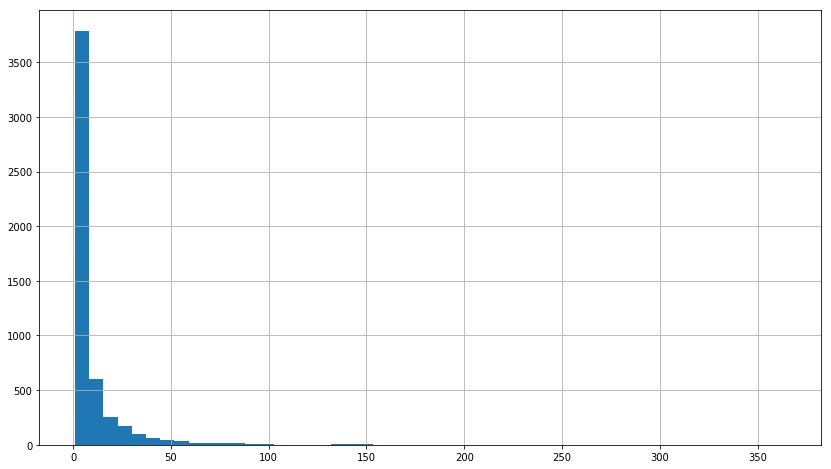

In [3]:
# Get counts of number of interactions per user
user_interactions_df = df['email'].value_counts()
user_interactions_df.hist(bins=50,figsize=(14,8))

In [4]:
user_interactions_df.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [6]:
# Find and explore duplicate articles
sum(df_content['article_id'].duplicated())

5

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(keep = 'first', inplace = True)
sum(df_content['article_id'].duplicated())

5

In [8]:
df['article_id'].nunique()

714

In [9]:
df_content['article_id'].nunique()

1051

In [10]:
df_real_users = df.dropna(subset=['email'])
df_real_users['email'].nunique()

5148

In [11]:
df.shape[0]

45993

In [13]:
popular_articles_df = pd.DataFrame(df['article_id'].value_counts())
popular_articles_df

,article_id
1429.0,937
1330.0,927
1431.0,671
1427.0,643
1364.0,627
1314.0,614
1293.0,572
1170.0,565
1162.0,512
1304.0,483


In [15]:
# Map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

We don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

In [17]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    # Get top article ids
    top_article_ids = get_top_article_ids(n)
    top_articles = []
    # For each top article id
    for article_id in top_article_ids:
        # Get article content
        article_content = df[df['article_id'] == article_id]
        article_content = article_content.head(1)
        top_articles.append(article_content.iloc[0]['title'])
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    popular_articles_df = pd.DataFrame(df['article_id'].value_counts())
    popular_articles_df = popular_articles_df.head(n)
    top_articles = popular_articles_df.index
    top_articles = [int(i) for i in top_articles]
 
    return top_articles # Return the top article ids

In [18]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>

In this section we will explore finding similar users as a means to make reccomendations.

We will reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    # Create matrix of users by articles
    user_by_article = df.groupby(['user_id', 'article_id'])['title'].count().notnull().unstack()
    # Replace nans with 0
    user_by_article = user_by_article.fillna(0)
    # Normalise non-zero values to 1
    user_by_article = user_by_article.apply(lambda x: [y if y == 0 else 1 for y in x])
    user_item = user_by_article
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [22]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # Compute similarity of each user to the provided user
    similarity_scores = user_item.dot(user_item.loc[user_id])
    # Sort by similarity score
    similarity_scores = similarity_scores.sort_values(ascending=False)
    # Remove the selected users id
    similarity_scores.drop(user_id, inplace=True)
    # Return list of ids in order
    most_similar_users = list(similarity_scores.index)
       
    return most_similar_users # return a list of the users in order from most to least similar

Now that we have a function that provides the most similar users to each user, we will want to use these users to find articles you can recommend. 

In [24]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Your code here
    article_names = []
    # For each article id
    for article_id in article_ids:
        # Convert to float
        article_id_num = float(article_id)
        # Get article
        article = df.loc[lambda df: df['article_id'] == article_id_num]
        # Save title into list
        article_names.append(article.iloc[0]['title'])
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Your code here
    user_id = int(float(user_id))
    # Get article ids
    article_ids = list(user_item.columns[np.where(user_item.loc[user_id]==1)])
    # Get article names
    article_names = get_article_names(article_ids)
    # Convert ids to strings
    article_ids = [str(i) for i in article_ids]
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Get users ordered by closeness to selected user
    similar_users = find_similar_users(user_id)
    # Get articles already seen by selected user
    article_ids_ignore, article_names_ignore = get_user_articles(user_id)
    # Initialise list of reccomendations
    recs = []
    # For each other user
    for similar_user_id in similar_users:
        # Get articles seen by current user
        article_ids, article_names = get_user_articles(similar_user_id)
        # For each article seen by this user
        for article_id in article_ids:
            # If article not already seen by selected user
            if article_id not in article_ids_ignore:
                # Add to reccomendations
                recs.append(article_id)
                # If we have reached desired number of reccomendations
                if len(recs) == m:
                    return recs # return your recommendations for this user_id 
    # If we have cycled through all users anyway
    return recs # return your recommendations for this user_id

In [25]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['this week in data science (april 18, 2017)',
 'timeseries data analysis of iot events by using jupyter notebook',
 'got zip code data? prep it for analytics. – ibm watson data lab – medium',
 'higher-order logistic regression for large datasets',
 'using machine learning to predict parking difficulty',
 'deep forest: towards an alternative to deep neural networks',
 'experience iot with coursera',
 'using brunel in ipython/jupyter notebooks',
 'graph-based machine learning',
 'the 3 kinds of context: machine learning and the art of the frame']

Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - we will choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. 

In [80]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # Take dot product of selected user x all users to get similarity scores
    similarity = user_item.dot(user_item.loc[user_id])
    # Sort by similarity & drop selected user
    similarity = similarity.sort_values(ascending=False).drop(user_id).to_frame(name='similarity').reset_index()
    # Get total number of interactions as a measure of interactions for each user (using df rather than user-item matrix)
    num_interactions = df.user_id.value_counts().to_frame('num_interactions')
    # Merge similarity scores with user interactions
    neighbors_df = similarity.merge(num_interactions, left_on='user_id', 
                        right_index=True).rename(columns={'user_id':'neighbor_id'})
    # Re-sort by similarity, then by number of interactions
    neighbors_df.sort_values(by=['similarity', 'num_interactions'], ascending=False, inplace=True)
    return neighbors_df # Return the dataframe specified in the doc_string


def get_user_articles2(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user - ordered by most interactions
    article_names - (list) a list of article names associated with the list of article ids - ordered by most interactions
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user, ordered by most interactions
    '''
    # Get article ids
    article_ids = list(user_item.columns[np.where(user_item.loc[user_id]==1)])
    # Create dataframe for interaction scores for articles
    interactions_lst = []
    # For each article id
    for article_id in article_ids:
        # Calculate total interactions for this article
        article_interactions = user_item[article_id].sum()
        # Append id and total interactions to dataframe
        interactions_lst.append([article_id, article_interactions])
    # Convert list to df
    interactions_df = pd.DataFrame(interactions_lst, columns=['article_id', 'num_interactions'])
    # Sort by number of interactions
    interactions_df = interactions_df.sort_values(by=['num_interactions'], ascending=False) 
    # Extract new order of article ids
    article_ids = interactions_df['article_id'].tolist()
    # Get article names
    article_names = get_article_names(article_ids)
    # Convert ids to strings
    article_ids = [str(i) for i in article_ids]
    return article_ids, article_names # return the ids and names

def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Lets check if this user exists
    try:
        user_article_ids, _ = get_user_articles(user_id)
    # If user does not exist yet
    except KeyError: 
        # Make rank-based reccomendations
        recs = get_top_article_ids(m)
        return recs, get_article_names(recs)
    
    # Get users ordered by closeness to selected user and interactions
    neighbors_df = get_top_sorted_users(user_id)
    # Get articles already seen by selected user
    article_ids_ignore, article_names_ignore = get_user_articles(user_id)
    # Initialise list of reccomendations
    recs = []
    # For each other user
    for index, row in neighbors_df.iterrows():
        # Get articles seen by current user, ordered by most interactive first
        article_ids, article_names = get_user_articles2(row.neighbor_id)
        # For each article seen by this user
        for article_id in article_ids:
            # If article not already seen by selected user
            if article_id not in article_ids_ignore:
                # Add to reccomendations
                recs.append(article_id)
                # If we have reached desired number of reccomendations
                if len(recs) == m:
                    # Get names
                    rec_names = get_article_names(recs)
                    return recs, rec_names # return your recommendations for this user_id 


In [75]:
# Quick spot check
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1330.0', '1364.0', '1427.0', '1160.0', '1351.0', '1336.0', '1304.0', '1368.0', '1170.0', '1338.0']

The top 10 recommendations for user 20 are the following article names:
['insights from new york car accident reports', 'predicting churn with the spss random tree algorithm', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'analyze accident reports on amazon emr spark', 'model bike sharing data with spss', 'learn basics about notebooks and apache spark', 'gosales transactions for logistic regression model', 'putting a human face on machine learning', 'apache spark lab, part 1: basic concepts', 'ml optimization using cognitive assistant']


In [76]:
get_top_sorted_users(1).neighbor_id.head(1)[0]

3933

In [77]:
get_top_sorted_users(131).neighbor_id.head(10)[9]

242

In [78]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).neighbor_id.head(1)[0] # Find the user that is most similar to user 1 
user131_10th_sim = get_top_sorted_users(131).neighbor_id.head(10)[9] # Find the 10th most similar user to user 131

**If we were given a new user we could use the rank-based reccomendation functions, as these do not rely on any exisiting selections/interactions. Once the user has interacted with a certain number of articles (to be determined) we would then move to using user-user collaberative filtering. We might even devise a new scheme that slowly transitions from one to the other, as the number of interactions increases.**

Provide the top 10 recommended articles we would provide for the a new user.  

In [148]:
new_user = '0.0'

# Provide a list of the top 10 article ids you would give to 
new_user_recs, new_user_recs_names =  user_user_recs_part2(0.0, 10)# Your recommendations here

# Convert rec ids to list of string-floats
new_user_recs = [float(i) for i in new_user_recs]
new_user_recs = [str(i) for i in new_user_recs]
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, I will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [152]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [153]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In this situation, we can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  

In [154]:
# Perform SVD on the User-Item Matrix

u, s, vt = np.linalg.svd(user_item_matrix)

**We can use SVD in this case because every entry in the matrix has a value (1 or 0). In the lesson we had a user-item matrix that had null (unknown) values.**

How do we choose the number of latent features to use?  Running the below cell, we can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  

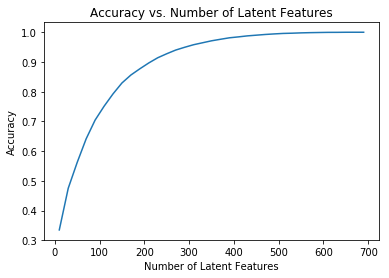

In [155]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

In [156]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create user-item matrices for train and test sets
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    # Get ids for all test users & articles
    test_idx = df_test.user_id.unique()
    test_arts = df_test.article_id.unique()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [157]:
train_idx = user_item_train.index
common_users = list(set(train_idx)&set(test_idx)) 
common_articles = user_item_train.columns.intersection(test_arts)
print(user_item_test.shape)
print(len(common_users))
print(len(common_articles))

(682, 574)
20
574


Now we will use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then we will find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In [160]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below
print(u_train.shape)
print(s_train.shape)
print(vt_train.shape)

(4487, 4487)
(714,)
(714, 714)


In [164]:
# Get indexes of the common users & articles in train and test 
train_users_common = user_item_train.index.isin(test_idx)
train_articles_common = user_item_train.columns.isin(test_arts)

# Great U & V transpose matrices for test based on common
u_test = u_train[train_users_common, :]
vt_test= vt_train[:, train_articles_common]

# Filter user-item matrix for test by common values so correct shape
user_item_test = user_item_test.loc[common_users]

print(u_test.shape)
print(vt_test.shape)
print(user_item_test.shape)

(20, 4487)
(714, 574)
(20, 574)


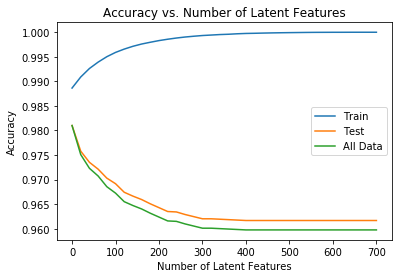

In [163]:
num_latent_feats = np.arange(0,700+10,20)
sum_errs_train = []
sum_errs_test = []
all_errs = []

# For each value for latent features
for k in num_latent_feats:
    
    # Restructure train & test matrices with k latent features
    s_train_lat, u_train_lat, vt_train_lat = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    u_test_lat, vt_test_lat = u_test[:, :k], vt_test[:k, :]
    
    # Take dot product of train & test matrices
    user_item_train_preds = np.around(np.dot(np.dot(u_train_lat, s_train_lat), vt_train_lat))
    user_item_test_preds = np.around(np.dot(np.dot(u_test_lat, s_train_lat), vt_test_lat))
    all_errs.append(1 - ((np.sum(user_item_test_preds)+np.sum(np.sum(user_item_test)))/(user_item_test.shape[0]*user_item_test.shape[1])))
    
    # Compute errors for each prediction to actual value for train & test
    diffs_train = np.subtract(user_item_train, user_item_train_preds)
    diffs_test = np.subtract(user_item_test.loc[common_users, :], user_item_test_preds)
    
    # Total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_train.append(err_train)
    sum_errs_test.append(err_test)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(user_item_train.shape[0]*user_item_test.shape[1]), label='Train');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(user_item_test.shape[0]*user_item_test.shape[1]), label='Test');
plt.plot(num_latent_feats, all_errs, label='All Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

**In a way this is a suprising result! While in the training set, performance increases with number of latent features - and with the test set the opposite is true, the more latent features, the worse the performance! This could in part be due to the train & test set sizes, the test set only has 20 users so this may cause it to generalise poorly, and more poorly as the number of latent features increases. The training set simply has more examples/data to be 'expressed' in more latent features - and thus may benefit more.**

<a id='conclusions'></a>

## Conclusion

In this project we explored a range or techniques to reccommend article content to users on the IBM Watson studio platform.